<br>
<b> Transients and Variable Stars in DP0.2</b> <br>
Contact author: Vincenzo Petrecca <br>
Last verified to run: 2024-06-07 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Use catalog data to identify Supernovae and Variable Stars, and plot their lightcurves.

**Skills:** Use various TAP tables, including joining multiple tables. Extract time-series photometry. Measure periods and plot phased lightcurves.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.Object, ForcedSource, CcdVisit, DiaObject, DiaSource, ForcedSourceOnDiaObject, TruthSummary. <br>

**Packages:** numpy, matplotlib, astropy.units, astropy.coordinates, astropy.io.fits, astropy.timeseries.LombScargle, lsst.rsp.get_tap_service.

**Credit:** Adapted from tutorial notebooks *DP02_07a* (author Melissa Graham), *DP02_07b* (authors Jeff Carlin and Ryan Lau), and *delegate-contribution-dp02/dia_exploration/dia_supernova.ipynb* (author Vincenzo Petrecca) for the DP0 Virtual Accademy 2024.<br>

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to use the Table Access Protocol (TAP) service to query the time-domain data products and plot their light curves.

In Section 2 a known RR Lyrae star is identified in the `Object` table, and then photometry is retrieved from the `ForcedSource` table. Recall that the `Object` table contains astrometric and photometric measurements for objects detected in coadded images, and that the `ForcedSource` table contains forced photometry on the individual processed visit images (PVIs; direct images) at the locations of all detected `Objects`. 
A Lomb-Scargle periodogram is used to identify the period and phase-fold the time-series photometry, and then a phase-folded lightcurve is displayed for the single RR Lyrae.

In Section 3 we derive photometry as above, this time looking for a type Ia Supernova (SNIa) from the `TruthSummary` table. We also look for the same source in the data products of difference image analysis (DIA). In particular, we identify the sorce in the `DiaObject` table, and we extract the photometry from the `DiaSource` and the `ForcedSourceOnDiaObject` tables. 

In Sections 4 and 5, we try to identify a sample of candidate SNIa or RR Lyrae stars by imposing specific conditions on the queries.

Differences between using time-series photometry for `DiaObjects` in the `DiaSource` or `ForcedSourceOnDiaObject` tables are stressed throughout this notebook. Both tables contain forced photometry in the PVI (direct image), but the `DiaSource` table only contains photometry for visits in which the
`DiaObject` was *detected in the corresponding difference image*,
whereas the `ForcedSourceOnDiaObject` table contains forced photometry for *all* PVIs and difference images.

> **Warning:** When variable stars are observed to have nearly the same brightness as they do in the template image,
they will not be detected in the difference image,
and photometry for that visit's PVI will not be included in the `DiaSource` table.

This notebook demonstrates that, for transients and variable stars, it is better to use either the `ForcedSource` or `ForcedSourceOnDiaObject` tables.

### 1.1 Package Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import unique
from astropy.timeseries import LombScargle
from astropy.cosmology import FlatLambdaCDM

from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

Set up some plotting defaults so plots will look nice:

In [2]:
%matplotlib inline
plt.style.use('tableau-colorblind10')

params = {'axes.labelsize': 13,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the _ugrizy_ bands. These colors are the same as those used for _ugrizy_ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Set the cosmology to use with the astropy.cosmology package.

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Start the TAP service, which we will use for all data retrieval in this notebook.

In [5]:
service = get_tap_service("tap")

## 2. Create a Lightcurve for a Known RR Lyrae Variable

To start out, we will use a star that is known (from the DC2 truth tables) to be a simulated RR Lyrae star in DC2. This will help us get our feet wet at extracting time-series data and manipulating them.



### 2.1 Extract Forced Photometry Measurements for a Pulsating Variable

The known RR Lyrae star we will use is at position (RA, Dec) = (62.1479031, -35.799138) degrees. We will initially look for this star in the `Object` table to identify its `objectId`. Then we will use this `objectId` to identify measurements of the star in the `ForcedSource` table.

The schema browser for each table is here: https://dm.lsst.org/sdm_schemas/browser/dp02.html

#### 2.1.1 Define star coordinates

Initialize two variables with the known position of the star of interest:

In [6]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

#### 2.1.2 Find the Star in the Object Table

Query the `Object` table for this star. We use a spatial query at the RA, Dec position of interest, and specify a very small area to search (0.001 degrees), so that we will retrieve only the star of interest.

Notice that in addition to selecting on position, we specify "detect_isPrimary = 1" as well. The <a href="https://pipelines.lsst.io/getting-started/multiband-analysis.html#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag">detect_isPrimary flag</a> is a composite flag that, if TRUE (or set to 1), ensures a unique, deblended source.

Notice also the use of the `scisql_nanojanskyToAbMag` function to convert fluxes to magnitudes. (This could also be done after extracting the fluxes if desired, but this step streamlines things.)

In [7]:
results = service.search("SELECT TOP 100 "
                         "coord_ra, coord_dec, objectId, "
                         "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "
                         "g_extendedness, r_extendedness, i_extendedness "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "
                         + str(dec_known_rrl) + ", 0.0001)) = 1 "
                         "AND detect_isPrimary = 1")

objs = results.to_table()

In [8]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,gPSFMag,rPSFMag,iPSFMag,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nJy,nJy,nJy,,,,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
62.1479018,-35.7991382,1651589610221899038,148048.9327607,185964.3848651,173109.3517536,True,18.473986797397433,18.226425555283118,18.304198674833767,0.0,0.0,0.0


Looks good - our limited search retrieved only a single object. Notice that the "extendedness" flag is zero for all three bands, meaning this object is likely a point source (i.e., a star). It is around 18th magnitude in all three bands, and has fairly blue colors as expected for an RR Lyrae star.

#### 2.1.3 Extract the Measurements from the Forced Source Table

Now that we have identified the candidate in the Object table, we can use its `objectId` to identify it in the `ForcedSource` table. First extract the `objectId`:

In [9]:
sel_objid = objs[0]['objectId']
print(sel_objid)

1651589610221899038


Now we will use this ID to pick out all measurements of this object from the `ForcedSource` table (by use of a WHERE statement in the query).

**N.B.** Note that we are also using a JOIN here to extract the visit info for each entry in `ForcedSource`. This is necessary so we can get the time each exposure was observed ("expMidptMJD") from the `CcdVisit` table, to be used in constructing lightcurves.

Define the query.

In [10]:
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


Execute the query, and extract the results to a table.

In [11]:
results = service.search(query)
srcs = results.to_table()
print(len(srcs))

432


Uncomment and execute the following cell to see what this table looks like.

In [12]:
srcs

band,ccdVisitId,coord_ra,coord_dec,objectId,psfFlux,psfFluxErr,psfMag,ccdVisitId2,band2,expMidptMJD,zeroPoint
,,deg,deg,,nJy,nJy,,,,d,mag
object,int64,float64,float64,int64,float64,float64,float64,int64,object,float64,float32
r,414861046,62.1479018,-35.7991382,1651589610221899038,131851.1538881,386.7600372,18.599790162874285,414861046,r,60166.3331702,32.1795
r,718818112,62.1479018,-35.7991382,1651589610221899038,170332.2843202,434.7878455,18.321757573086906,718818112,r,60643.0669522,32.178
r,943324129,62.1479018,-35.7991382,1651589610221899038,146328.0393507,421.0905817,18.48668111618875,943324129,r,60961.2457292,32.1715
r,943325140,62.1479018,-35.7991382,1651589610221899038,147724.9138055,424.9277484,18.476365636875673,943325140,r,60961.2461782,32.1696
r,414892047,62.1479018,-35.7991382,1651589610221899038,129683.0533897,381.2756228,18.617791931420474,414892047,r,60166.3471312,32.1781
r,721835057,62.1479018,-35.7991382,1651589610221899038,176142.8397585,447.0436574,18.28533751570267,721835057,r,60647.1295272,32.1727
r,753606017,62.1479018,-35.7991382,1651589610221899038,141989.9975897,417.7439037,18.519355620461383,753606017,r,60693.1292282,32.1784
r,718857011,62.1479018,-35.7991382,1651589610221899038,165033.4966435,424.895895,18.356069746571297,718857011,r,60643.0845602,32.1775


#### 2.1.4 Select Forced Photometry Measurements from Each Band

The `ForcedSource` table contains measurements from all bands (i.e., _ugrizy_ filters). It will be useful to extract measurements for each band by selecting on the "band" column.

In the following cell, and throughout this notebook, we store arrays in a python dict (in this case, one called "pick") that is indexed on the "band" or "filter" name.

In [13]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

In [14]:
# pick

Plot the observed "lightcurve" for the _r_ band.

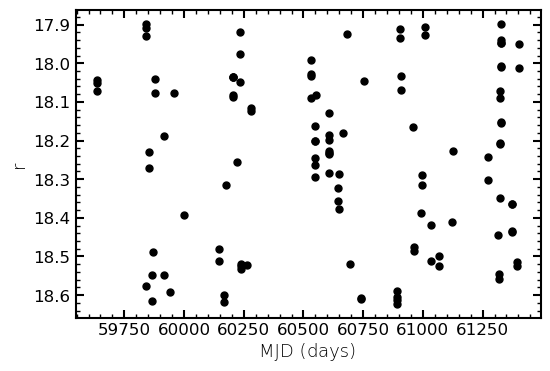

In [15]:
fig = plt.figure(figsize=(6, 4))
plt.plot(srcs[pick['r']]['expMidptMJD'], srcs[pick['r']]['psfMag'],
         'k.', ms=10)
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.show()

There is a spread of almost 1 magnitude, so clearly we have identified a variable star. Hooray!

### 2.2 Create a Phased Lightcurve

In the plot above, it is clear that this is a variable star, but we want to know more about it. Assuming it is a periodic variable, let's try to estimate its period so we can create a phased lightcurve.

> **Caveat:** The author of this notebook is not an expert in periodic variables or analysis of time-series data. The following is almost certainly not the **best** way of doing these analyses, but is simply one way to do things. It is shown here as a demonstration only.

A common way of searching for periodicity in unevenly-sampled time-series data is the Lomb-Scargle Periodogram. In this section we will create such a periodogram using the <a href="https://docs.astropy.org/en/stable/timeseries/lombscargle.html">Lomb-Scargle package from Astropy</a>. We will then estimate the best period, and reference all observations to that period to create a phased lightcurve.


#### 2.2.1 Extract and Plot a Periodogram

For convenience, we first extract all of the times of observation and measured magnitudes to separate arrays for each bandpass.

In [16]:
mjd_days = {}
mags = {}
for filter in plot_filter_labels:
    mjd_days[filter] = np.array(srcs[pick[filter]]['expMidptMJD']) * u.day
    mags[filter] = np.array(srcs[pick[filter]]['psfMag'])

The Lomb-Scargle periodogram returns the power at different frequencies. Because we know this is an RR Lyrae star, its period must be between ~0.2-0.9 days. We will use the min/max frequency settings to limit our period search to 0.05-1.05 days. (Recall that frequency is 1/period.)

In [17]:
min_period = 0.05 * u.day
max_period = 1.05 * u.day

min_freq_search = 1.0 / max_period
max_freq_search = 1.0 / min_period

Now we run the LombScargle algorithm on each of these datasets. We will set only the min/max frequencies, and otherwise use the "autopower" method from LombScargle. 

In [18]:
frequency = {}
power = {}
for filter in plot_filter_labels:
    frequency[filter], power[filter] =\
        LombScargle(mjd_days[filter], mags[filter]).autopower(minimum_frequency=min_freq_search,
                                                              maximum_frequency=max_freq_search)


In a well-behaved and well-sampled scenario, the Lomb-Scargle power will peak at a specific frequency that corresponds to the period of the star's variability.

We will assume that the frequency returning the highest power corresponds to the real period of the star (which is not necessarily true in the case of real data with uneven sampling, period aliasing, and other effects). Let's find this frequency for each band.

In the following cell, we find the index with the maximum power and assign it as the "peakbin" and then store the frequency according to the peak power. Then we calculate the mean frequency and period from the peak frequencies of the results from all the filters.

In [19]:
all_peak_freqs = []

for filter in plot_filter_labels:
    peakbin = np.argmax(power[filter])

    all_peak_freqs.append(frequency[filter][peakbin].value)
    
all_peak_freqs = np.array(all_peak_freqs)

mean_peak_freq = np.mean(all_peak_freqs)

print('Mean frequency:', mean_peak_freq)
print('Mean period:', 1.0/mean_peak_freq, ' days')
print('\nugrizy frequency results:\n', all_peak_freqs)

Mean frequency: 1.962589383860051
Mean period: 0.5095309330743371  days

ugrizy frequency results:
 [1.96261051 1.96261062 1.96261288 1.96252393 1.96255106 1.9626273 ]


Plot a "periodogram" -- a figure showing the power vs. frequency from the Lomb-Scargle analysis. We'll also add a panel for the period. (This figure shows only the r-band results. You could try it with others!)

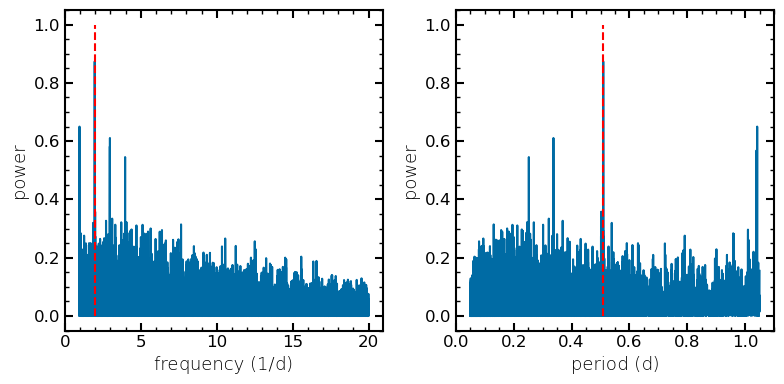

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
plt.plot(frequency['r'], power['r'])
plt.vlines(mean_peak_freq, 0, 1, linestyle='--', color='red')
plt.minorticks_on()
plt.xlabel('frequency (1/d)')
plt.ylabel('power')

plt.sca(ax[1])
plt.plot(1 / frequency['r'], power['r'])
plt.vlines(1/mean_peak_freq, 0, 1, linestyle='--', color='red')
plt.minorticks_on()
plt.xlabel('period (d)')
plt.ylabel('power')

plt.tight_layout()
plt.show()

#### 2.2.2 Create a Phased Lightcurve

The red line we overlaid on the previous plot corresponds to a clear peak in the periodogram, so it looks like we have found a good estimate of the period. Now we will use that period to extract and plot phased light-curves of the variable star.

Recall that period = 1/frequency:

In [21]:
best_period = 1/mean_peak_freq

To "phase" the lightcurves, we calculate how many periods have passed since some fiducial time "t0". Here, we select t0 to be the time of the first g-band observation, but that is completely arbitrary.

The second part takes only the non-integer part of the number of elapsed periods. For example, a point that happens 2.75 periods after t0 will have phase 0.75.

In [22]:
mjd_norm = {}
phase = {}

t0 = np.min(mjd_days['g'].value)

for filter in plot_filter_labels:
    mjd_norm[filter] = (mjd_days[filter].value - t0) / best_period
    phase[filter] = np.mod(mjd_norm[filter], 1.0)

Now plot them separately for each band (using an integer offset to separate them):

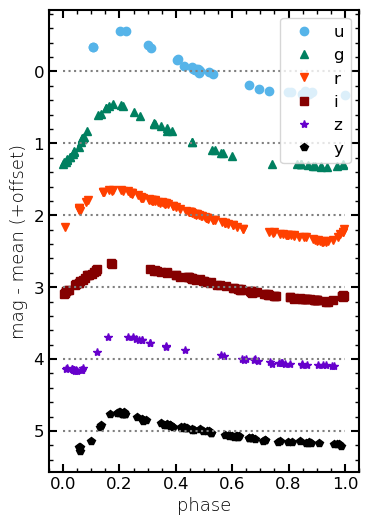

In [23]:
fig = plt.figure(figsize=(4, 6))

i = 0

for filter in plot_filter_labels:
    plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]) + i,
             plot_filter_symbols[filter],
             color=plot_filter_colors[filter], label=filter)
    plt.hlines(i, 0, 1, linestyle=':', color='Gray')
    i += 1

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean (+offset)')
plt.minorticks_on()
plt.show()

...and all together:

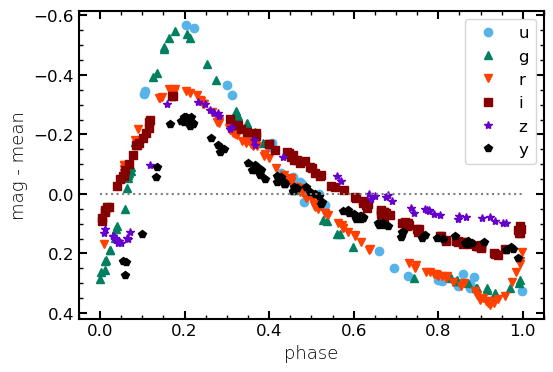

In [24]:
fig = plt.figure(figsize=(6, 4))

for filter in plot_filter_labels:
    plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]),
             plot_filter_symbols[filter],
             color=plot_filter_colors[filter], label=filter)
plt.hlines(0, 0, 1, linestyle=':', color='Gray')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean')
plt.minorticks_on()
plt.show()

Success! That looks like an RR Lyrae star. 

## 3. Create a Lightcurve for a transient source

Now we produce a new lightcurve for a transient, but we first get the coordinates from the truth table. 

### 3.1 Get the coordinates for a SN Ia from the truth table

Query the truth match catalog with the TAP service. Use coordinates near the center of DC2. Use a 0.5 degree radius. Use is_variable = 1 (true) to only return variables. Use is_variable = 1 (true) to only return variables. Use truth_type = 3 to only return Type Ia Supernovae. Use is_unique_truth_entry = 'true' to ensure good truth-table matches only. Use redshift < 0.3 to be more likely to get a full light curve with lots of data points.

#### 3.1.1 Define the query

Get the coordinates and all the useful information through the query. 

In [25]:
%%time
results = service.search("SELECT ts.ra, ts.dec, ts.id, ts.host_galaxy, ts.redshift "\
                         "FROM dp02_dc2_catalogs.TruthSummary AS ts "
                         "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), "\
                         "CIRCLE('ICRS', 64.0, -35.5, 0.5)) = 1 "\
                         "AND ts.is_variable = 1 AND ts.truth_type = 3 AND ts.redshift < 0.3 ",\
                         maxrec=100)

CPU times: user 10.7 ms, sys: 175 µs, total: 10.9 ms
Wall time: 574 ms


Execute the query, and extract the results to a table. You can also extract the table as a Pandas DataFrame, if you prefer.

In [26]:
data = results.to_table().to_pandas()
data

,ra,dec,id,host_galaxy,redshift
0,63.393018,-35.527025,MS_9686_54,7000042166,0.216546
1,63.446107,-35.667591,MS_9686_17,7000016077,0.156973
2,63.439070,-35.698616,MS_9686_51,7000042054,0.212700
3,64.550258,-35.480998,MS_9559_143,6062585964,0.272381
4,64.485723,-35.655049,MS_9686_5,7000002405,0.083210
5,64.450723,-35.646013,MS_9686_45,7000042951,0.229568
6,64.517812,-35.619112,MS_9686_6,7000004891,0.114768
7,64.278683,-35.600777,MS_9686_92,7000060876,0.253165
8,64.258097,-35.642412,MS_9686_103,7000060064,0.261563
9,64.213578,-35.888663,MS_9686_67,7000041679,0.233821


#### 3.1.2 Select a SN and define the coordinates

Use Pandas to loc on a specific object.

In [27]:
SN = data.loc[data['id'] == 'MS_9686_140']

Get the coordinates of the selected SN in degrees.

In [28]:
SN_ra, SN_dec = SN['ra'].values[0]*u.deg, SN['dec'].values[0]*u.deg
targ_coord = SkyCoord(ra=SN_ra,dec=SN_dec)

#### 3.1.3 Find the SN in the Object Table

Now get the `objectId` for these specific coordinates, as we did before for the variable star.

In [29]:
results = service.search("SELECT TOP 100 "
                         "coord_ra, coord_dec, objectId, "
                         "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "
                         "g_extendedness, r_extendedness, i_extendedness "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS'," + str(SN_ra.value) + ", "
                         + str(SN_dec.value) + ", 0.0001)) = 1 "
                         "AND detect_isPrimary = 1")

objs = results.to_table()

In [30]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,gPSFMag,rPSFMag,iPSFMag,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nJy,nJy,nJy,,,,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
64.257265,-35.4377439,1737061246118692424,2.822535,93.5938517,206.1453767,True,30.27340166007735,26.471881699214155,25.614566002098268,1.0,1.0,1.0


#### 3.1.4 Extract the Measurements from the Forced Source Table

In [31]:
sel_objid = objs[0]['objectId']
print(sel_objid)

1737061246118692424


Get the photometry by querying the `ForcedSource` table to build the lightcurve.

**N.B.** The table does not contain the time each exposure was observed. To build the lightcurve, we use a JOIN to extract visit info for each entry from the `CcdVisit` table.

In [32]:
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


Run the query, and extract the results to a table.

In [33]:
results = service.search(query)
srcs = results.to_table()
print(len(srcs))

428


Uncomment and execute the following cell to see what this table looks like.

In [34]:
# srcs

Extract measurements for each band separately.

In [35]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

Plot the observed lightcurve for the *r* band.

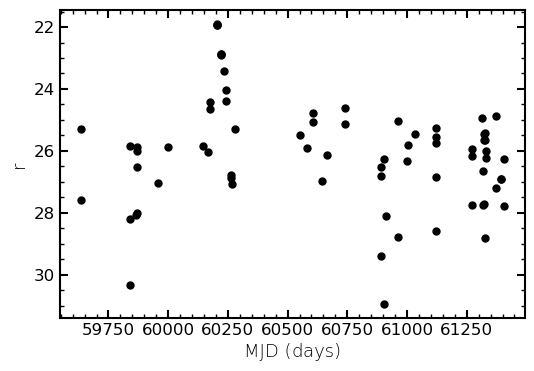

In [36]:
fig = plt.figure(figsize=(6, 4))
plt.plot(srcs[pick['r']]['expMidptMJD'], srcs[pick['r']]['psfMag'],
         'k.', ms=10)
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.show()

We see a peak of 22 r-mag around 60250 days (MJD). This might be a SN, but a 5-years lightcurve is not very informative for transients! 

### 3.2 Use the DIA data products

For transients such as Supernovae, it is better to look at data products from difference image analysis (DIA), where sources are detected and measured on the _difference_ image resulting from subtracting an approriately scaled deep coadd template of the same sky area from a processed visit image (PVI), are a good place to check for transient and variable objects.

The three DIA products we will use are:

- `DiaObject`: table of all spatially unique objects detected in all difference images (all `DiaSources` associated by coordinate)
- `DiaSource`: table of sources detected in the difference images
- `ForcedSourceOnDiaObject`: table of forced photometry in all PVI and all difference images at the location of all `DiaObjects`

The DP0.2-era `DiaObject` table contains summary statistics for each object, which we can use to identify candidate variables.
In the future, this table will contain additional variability measurements as described in the Data Management Tech Note (DMTN) "Review of Timeseries Features", <a href="https://dmtn-118.lsst.io">DMTN-118</a>.


Every time a source is detected on a difference image with *Signal-to-noise ratio > 5*, a new entry is added to the `DiaSource` table. Multiple detections associated to the same object will have the same *diaObjectId*, otherwise a new Id is created. 

The `DiaObject` table contains a single entry for each variable/transient object. 
We can query the `DiaObject` table to get the Id of the Supernova (assuming a simple coordinate matching for simplicity). Then, use the retrieved Id to get the lightcurve from the `DiaSource` table.

#### 3.2.1 Find the chosen Supernova on the *DiaObject* table

We only need the *DiaObjectId* for this query, and we will take the closest match within 0.5 arcsec.

In [37]:
results = service.search("SELECT ra, decl, diaObjectId "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         "CIRCLE('ICRS'," + str(targ_coord.ra.deg) + ", "
                         + str(targ_coord.dec.deg) + ", 0.00014)) = 1 ", maxrec=100000)

DiaObjs = results.to_table()
del results

In [38]:
DiaObjs

ra,decl,diaObjectId
deg,deg,
float64,float64,int64
64.2572626,-35.4377732,1737061246118659524


In [39]:
sel_objid = DiaObjs[0]['diaObjectId']
print(sel_objid)

1737061246118659524


#### 3.2.2 Extract the Photometry from the DiaSource Table
To get a lightcurve, we query for times (midPointTai) and fluxes (with related errors). Rubin will provide fluxes in nanoJansky by default, but it is possible to convert them into magnitudes easily. 

There are two different types of measurement on the `DiaSource` table: *psFlux* is the PSF flux measured on the difference image, while *totFlux* is the PSF flux measured on the direct image (the PVI, or *calexp*).

In [40]:
results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, ccdVisitId, "
                         "filterName, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag, "
                         "scisql_nanojanskyToAbMag(totFlux) AS totAbMag, "
                         "scisql_nanojanskyToAbMagSigma(psFlux, psFluxErr) AS psAbMagErr, "
                         "scisql_nanojanskyToAbMagSigma(totFlux, totFluxErr) AS totAbMagErr "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId = "+str(sel_objid))

DiaSrcs = results.to_table()
del results

Now we can separate the photometry for each bands. This is an alternative method using boolean masks and list indexing.

In [41]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (DiaSrcs['filterName'] == filter)

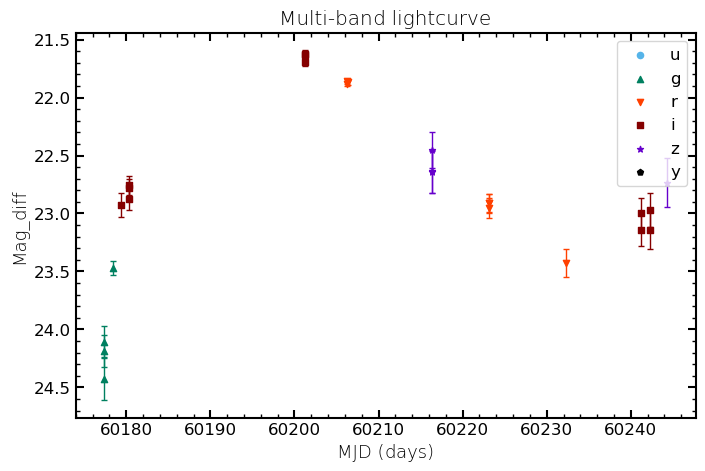

In [42]:
fig = plt.figure(figsize=(8, 5))

for f in plot_filter_labels:
    
    # Simple scatter plot with points
    plt.scatter(DiaSrcs[pick[f]]['midPointTai'], DiaSrcs[pick[f]]['psAbMag'],marker = plot_filter_symbols[f],
               s = 20, color = plot_filter_colors[f], label = f)
    # Light curve with error bars
    plt.errorbar(DiaSrcs[pick[f]]['midPointTai'], DiaSrcs[pick[f]]['psAbMag'],
                xerr = None, yerr = DiaSrcs[pick[f]]['psAbMagErr'], lw = 0, 
                elinewidth = 1, marker = plot_filter_symbols[f], markersize = 2, capsize = 2, color = plot_filter_colors[f])

plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD (days)')
plt.ylabel('Mag_diff')
plt.legend(loc='upper right')
plt.title("Multi-band lightcurve")
plt.show()

#### 3.2.4 Extract the Photometry from the ForcedSourceOnDiaObject Table
It may be useful to look at the lightcurve using Forced-photometry measurements on individual single-epoch visit images and difference images (whether or not the source has been detected above 5 sigma S/N). This information is provided in the `ForcedSourceOnDiaObject` table.

**N.B.** The table does not contain the time each exposure was observed. To build the lightcurve, we use a JOIN to extract visit info for each entry from the `CcdVisit` table.

In [43]:
results = service.search("SELECT frc.coord_ra, frc.coord_dec, frc.diaObjectId, frc.ccdVisitId, "
                         "frc.psfDiffFlux, frc.psfDiffFluxErr, frc.psfFlux, frc.psfFluxErr, "
                         "scisql_nanojanskyToAbMag(psfDiffFlux) AS psAbMag, "
                         "scisql_nanojanskyToAbMag(psfFlux) AS totAbMag, "
                         "scisql_nanojanskyToAbMagSigma(psfDiffFlux, psfDiffFluxErr) AS psAbMagErr, "
                         "scisql_nanojanskyToAbMagSigma(psfFlux, psfFluxErr) AS totAbMagErr, "
                         "visinfo.ccdVisitId, visinfo.band, visinfo.expMidptMJD, visinfo.zeroPoint "
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject AS frc "
                         "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "
                         "ON visinfo.ccdVisitId = frc.ccdVisitId "
                         "WHERE frc.diaObjectId = " + str(sel_objid) +
                         "AND frc.psfDiffFlux_flag = " + str(0) +
                         "AND frc.psfFlux_flag = " + str(0))

ForcedSrcs = results.to_table()
del results

Let's plot the lightcurves as above

**N.B.** We omit error bars to make the plots easier to read 

In [44]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (ForcedSrcs['band'] == filter)

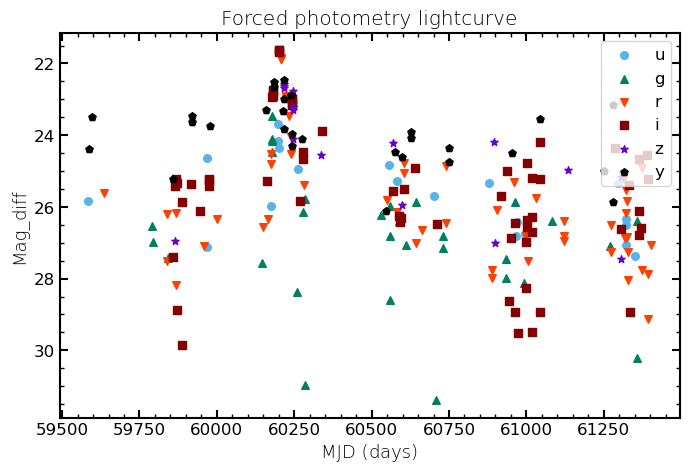

In [45]:
fig = plt.figure(figsize=(8, 5))

for f in plot_filter_labels:
    plt.scatter(ForcedSrcs[pick[f]]['expMidptMJD'], ForcedSrcs[pick[f]]['psAbMag'],marker = plot_filter_symbols[f],
               s = 30, color = plot_filter_colors[f], label = f)

plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD (days)')
plt.ylabel('Mag_diff')
plt.legend(loc='upper right')
plt.title("Forced photometry lightcurve")

plt.show()

We do not need to look at all visits, we can just "zoom" around the peak.

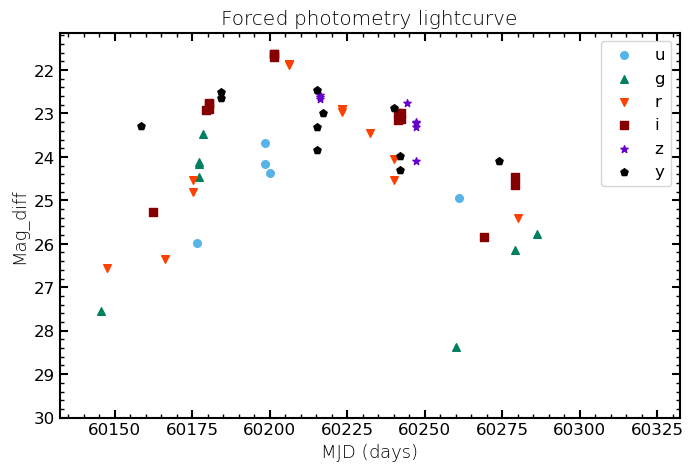

In [46]:
fig = plt.figure(figsize=(8, 5))

for f in plot_filter_labels:
    plt.scatter(ForcedSrcs[pick[f]]['expMidptMJD'], ForcedSrcs[pick[f]]['psAbMag'],marker = plot_filter_symbols[f],
               s = 30, color = plot_filter_colors[f], label = f)

plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD (days)')
plt.ylabel('Mag_diff')
plt.legend(loc='upper right')
plt.title("Forced photometry lightcurve")

# Zoom around the peak (rembember the magnitude scale is reversed!)
peak = np.argmin(ForcedSrcs[pick['i']]['psAbMag'])
plt.xlim(ForcedSrcs[peak]['expMidptMJD']-100,ForcedSrcs[peak]['expMidptMJD']+100)
plt.ylim(30)

plt.show()

## 4. Identify DiaObjects that are potential Type Ia Supernovae

Now we can try to identify a sample of ***potential*** low-redshift, well-sampled SN Ia.

Compared to other types of supernovae, SN Ia have homogenous lightcurves with very similar peak absolute brightnesses (about -19 mag in B-band), and similar rise and decline times (i.e., similar observed lightcurve amplitudes and durations, for a survey with a given limiting magnitude).

In LSST-like data sets with an r-band limiting magnitude of about 24.5 mag, such as the DC2 simulation, low-redshift SNIa (0.1 < _z_ < 0.3) lightcurves would look approximately like those plotted in the image below.

<img src="template_lowz_Vband.png" width=400>

In this example, the expected peak brightnesses, amplitude, and duration for the lightcurves of low-redshift SNIa are used to construct a TAP query on the DiaObjects table to identify a sample of ***potential*** SNIa.

> **Warning:** The following is a very rough, back-of-the-envelope way to identify a bunch of DiaObjects with parameters that suggest they are SNIa-like. The resulting sample is not scientifically useful (not pure, not complete) – it is just a few simple cuts that will get you a bunch of DiaObjects for which we can demonstrate how to plot lightcurves using the DiaSource table. Real SN-finding algorithms are photometric classifiers that fit the lightcurves with templates, rigorously, and provide probabilistic classifications. The text in Section 1 of the notebook describes this.

### 4.1. Establish lightcurve parameter constraints to identify potential SNIa

Define the desired redshift boundaries, the known approximate peak absolute magnitude for SNeIa (-19 mag), and the desired peak range to use to create the TAP query. This range roughly includes the intrinsic diversity in SNIa brightness and color, and host-galaxy reddening.

In [47]:
redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

Use the astropy.cosmology package to convert redshift to distance modulus. 
Define the minimum and maximum peak apparent r-band magnitudes -- allowing for the intrinsic diversity range specified above -- to use in the 
TAP query.

In [48]:
snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range
print('The minimum and maximum apparent r-band magnitudes '
      'to use in the TAP query are %5.2f and %5.2f mag.' %
      (snia_peak_mr_min, snia_peak_mr_max))

The minimum and maximum apparent r-band magnitudes to use in the TAP query are 18.82 and 22.46 mag.


Define maximum magnitudes in the g- and i-bands to use in the TAP query. The point of this is to simply enforce detection in at least the three filters g, r, and i. With knowledge of SNIa colors, this could be made more constraining, but for the purposes of this example these values are fine.

In [49]:
snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

Define the r-band minimum and maximum lightcurve amplitudes to use in the TAP query (i.e., the difference between the brightest and faintest detections in the difference image, in magnitudes). Well-sampled, low-redshift SNIa should be observed to change by at least 1.5 mag (_z_=0.3), and up to 5.5 mag (_z_=0.1).

In [50]:
snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

Define the minimum and maximum number of DiaSources (i.e., difference-image detections) to use in the TAP query.
The goal of this example is to identify potential _well-sampled_ Type Ia supernovae, and here a minimum of 15 detections is used.
Since the DC2 dataset was simulated using a baseline observing strategy (and does not include deep drilling fields), there are no more than 100 visits per year per field.
Any DiaObject with >100 DiaSources had a duration >1 year, and is not a SNIa.

In [51]:
snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

Define the minimum and maximum lightcurve duration, in days. 
The duration is the time between the first and last difference-image detection in any filter.
As seen in the template lightcurve plot above, SNIa at redshifts 0.1 < _z_ < 0.3 will have durations of 50 to 300 days.

In [52]:
snia_duration_min = 50
snia_duration_max = 300

> **Notice:** Of the above parameters defined to identify potential SNIa, only the lightcurve duration is _not_ represented in the DiaObjects table, and cannot be included as a constraint in the TAP query used below.
Instead, the lightcurve durations are calculated and used in Section 3.3.

### 4.2. Retrieve a sample of potentially SNIa-like DiaObjects

Only retrieve 1000 DiaObjects for this example.
When the TAP query completes, transfer the results to an astropy table.

This TAP query takes about a minute.

Note the use of the function `scisql_nanojanskyToAbMag` to retrieve magnitudes directly rather than having to convert them from fluxes after the query.

In [53]:
results = service.search("SELECT TOP 1000 "
                         "ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ")

DiaObjs = results.to_table()
DiaObjs['rMagAmp'] = DiaObjs['rMagMin'] - DiaObjs['rMagMax']
del results

### 4.3. Calculate lightcurve duration and identify potential SNIa

The lightcurve duration -- time between the first and last detected DiaSource in any filter -- is not included in the DiaObject table.
It is calculated below, using all of the DiaSources for each DiaObject.

Time is reported in the DiaSource table as `midPointTai`, which is in the SI unit of "TAI" (<a href="https://en.wikipedia.org/wiki/International_Atomic_Time">International Atomic Time</a>), and is presented in days (in particular, as "<a href="https://en.wikipedia.org/wiki/Julian_day">Modified Julian Days</a>").

First, create a string list of the `diaObjectId` that is formatted like "(1249546586455802795, 1248684569339625641, 1248684569339626125)".

In [54]:
all_ids = DiaObjs['diaObjectId']
temp_list = '('
for i, id in enumerate(all_ids):
    temp_list = temp_list + str(id)
    if i < len(all_ids)-1:
        temp_list = temp_list + ', '
    elif i == len(all_ids)-1:
        temp_list = temp_list + ')'

Uncomment this cell to print the 1000-element long list.

In [55]:
# print(temp_list)

Retrieve the `midPointTai` for all observations (`diaSource`s) for all the `diaObject`s.

In [56]:
results = service.search("SELECT diaObjectId, midPointTai "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId IN " + temp_list)
results = results.to_table()

Calculate the durations for each `diaObject` and add them to the `DiaObjs` table.

In [57]:
DiaObjs['duration'] = np.zeros(len(DiaObjs), dtype='float')

for j, DiaObjId in enumerate(DiaObjs['diaObjectId']):
    tx = np.where(results['diaObjectId'] == DiaObjId)[0]
    DiaObjs['duration'][j] = np.max(results['midPointTai'][tx]) - np.min(results['midPointTai'][tx])
    del tx

Clean up.

In [58]:
del results

Select only DiaObjects that have lightcurve durations within the specified range for SNIa.

In [59]:
tx = np.where((DiaObjs['duration'] > snia_duration_min)
                 & (DiaObjs['duration'] < snia_duration_max))[0]
print(len(tx))

44


**Plot a histogram of lightcurve durations, and a scatter plot of duration vs. amplitude, for the potential SNIa**

Plot a histogram of lightcurve durations (left) and a plot of duration versus r-band amplitude (right) to further characterize this sample of potential SNIa. 

Notice the spread in duration, and how it is correlated with lightcurve amplitude, as expected for SNIa. 

Tracking down the origin of the two outliers is left as an exercise for the learner: if they are truly SNIa observed for >100 days, then they should have a brighter amplitude.

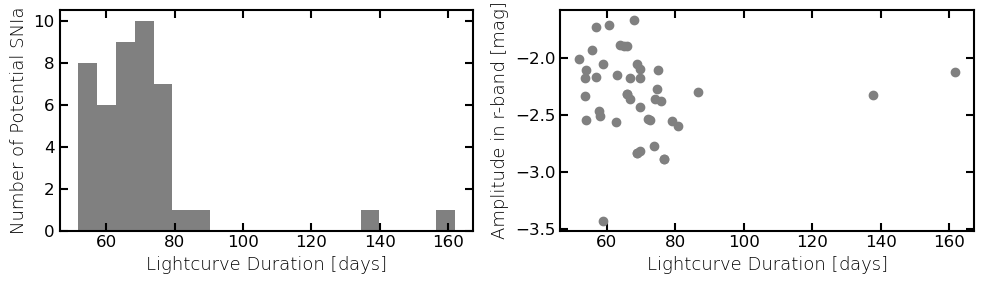

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['duration'][tx], bins=20, color='gray')
ax[0].set_xlabel('Lightcurve Duration [days]')
ax[0].set_ylabel('Number of Potential SNIa')

ax[1].plot(DiaObjs['duration'][tx], DiaObjs['rMagAmp'][tx], 'o', color='gray')
ax[1].set_xlabel('Lightcurve Duration [days]')
ax[1].set_ylabel('Amplitude in r-band [mag]')

plt.tight_layout()
plt.show()

### 4.4. Plot multi-band lightcurves for the first 20 potential SNIa

Notice that all of these lightcurves do resemble Type Ia supernovae!
That is a promising sign that the methodology of using the DiaObject summary parameters, along with the lightcurve duration (which must be calculate separately), can identify an initial sample of potential SNIa.

> **Keep in mind that this is not necessarily a pure or complete sample of SNIa,** just a sample of *potential well-sampled low-redshift* SNIa - decent enough to use as a demonstration, or a starting point for a more rigorous classification process.
Different science goals will have different requirements on sample identification.

Below, the lightcurves plotted are based on the signal-to-noise ratio > 5 detections from the DiaSource table only.
In Section 4, lightcurves based on forced photometry are used instead.

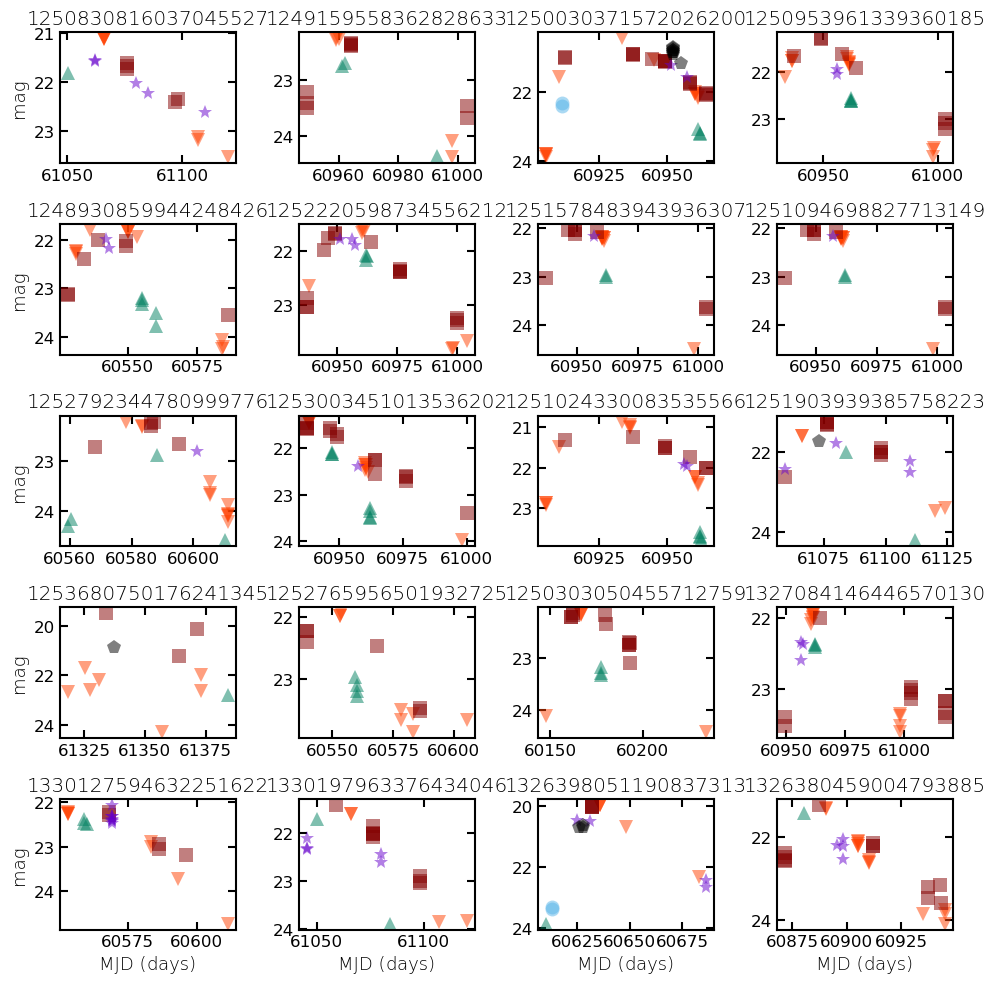

In [61]:
fig, ax = plt.subplots(5, 4, figsize=(10, 10), sharey=False, sharex=False)

x = 0

for i in range(5):
    for j in range(4):
        results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                                 "filterName, midPointTai, "
                                 "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                                 "FROM dp02_dc2_catalogs.DiaSource "
                                 "WHERE diaObjectId = "+str(DiaObjs['diaObjectId'][tx[x]]))
        results = results.to_table()

        for f, filt in enumerate(plot_filter_labels):
            fx = np.where(results['filterName'] == filt)[0]
            ax[i, j].plot(results['midPointTai'][fx], results['psAbMag'][fx],
                          plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                          color=plot_filter_colors[filt])
            del fx

        ax[i, j].invert_yaxis()
        ax[i, j].set_title(DiaObjs['diaObjectId'][tx[x]])

        if i == 4:
            ax[i, j].xaxis.set_label_text('MJD (days)')
        if j == 0:
            ax[i, j].yaxis.set_label_text('mag')

        x += 1
        del results

plt.tight_layout()
plt.show()

## 5. Identify Candidate RR Lyrae From Catalogs

Now that we know we can extract a lightcurve, find the star's period, and plot phased lightcurves for a _known_ RR Lyrae star, we move on to exploring how to _find_ candidate variables based on data in the catalogs.


For simplicity, the RR Lyrae candidate search we will conduct in this section will be a cone search centered at the coordinates of the known RR Lyrae from the previous section (RA, Dec = 62.1479031, -35.799138) with a 5 degree search radius.

### 5.1 Query DiaObject and ForcedSourceOnDiaObject to Retrieve Candidates and Photometry

The `DiaObject` table has several parameters that characterize the variability of `DiaSource` flux measurements (see the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#DiaObject">DP0.2 Schema Browser</a> for a full list).
These include the min/max fluxes, and various statistical measures of the scatter in flux measurements.
A particularly useful statistic for variable stars is the "StetsonJ" statistic, based on <a href="https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S/abstract">this 1996 paper</a>.
Variable stars have flux that varies more than expected based on the measurement uncertainties.
High values of the StetsonJ index should identify objects whose fluxes varied much more than expected -- i.e., variable stars.
Here we use StetsonJ>20, but users are encouraged to explore this and other statistics.

Here are all of the criteria we apply to our selection from `DiaObject`:

 1. g-band measurements only
 2. coordinates within 5 degrees of our chosen RA, Dec position
 3. `gTOTFluxSigma`/`gTOTFluxMean` > 0.25 -- the scatter in measured fluxes is larger than 25% relative to the mean
 4. `gTOTFluxSigma`/`gTOTFluxMean` < 1.25 -- the scatter in measured fluxes is no larger than 125% relative to the mean
 5. 18 < `diao_gmag` < 23 -- mean g magnitude between 18-23
 6. `gPSFluxNdata` > 30 -- at least 30 observations in g band
 7. `gPSFluxStetsonJ` > 20 -- StetsonJ index greater than 20 

In the ADQL query below, we implement all of these criteria and perform a table JOIN between `DiaObject` and `ForcedSourceOnDiaObject`,
the latter of which contains point-source forced-photometry measurements on processed visit images and difference images.
Since we are looking for **variable** candidates, which do appear in the template image,
we use the forced-photometry measurements from the **non-substracted** processed visit images (PVIs), also called the "direct" images.

We must perform one more table JOIN using the `ccdVisitId` from `FourcedSourceOnDiaObject` in order to get the MJD of each visit
from the `CcdVisit` table.
Note that the order of the table JOIN functions is important, and a different order may change the result of the search. 

In [62]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxMin, diao.gPSFluxMax, diao.gPSFluxMean, diao.gPSFluxSigma, "\
        "diao.gPSFluxMAD, diao.gPSFluxChi2, diao.gPSFluxNdata, diao.gPSFluxSkew, "\
        "diao.gPSFluxStetsonJ, diao.gPSFluxPercentile05, diao.gPSFluxPercentile25, "\
        "diao.gPSFluxPercentile50, diao.gPSFluxPercentile75, diao.gPSFluxPercentile95, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(diao.gTOTFluxMean) as diao_gmag, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "cv.expMidptMJD, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND fsodo.band = 'g' "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
fsodo_sources = results.to_table()

Uncomment the following cell to view the results table.

In [63]:
#fsodo_sources

We can also check out the number of unique `DiaObjects` and the total number of measurements from the following cell.

In [64]:
print(len(fsodo_sources), len(np.unique(fsodo_sources['diaObjectId'])))

702 14


The statement and its output above tells us that the query returned 14 unique `DiaObjects`, with a total of 702 measurements in `ForcedSourceOnDiaObject`.

In the following cell, we show the unique `DiaObjects` and their coordinates.


In [65]:
unique(fsodo_sources,keys = 'diaObjectId')['diaObjectId','ra','decl']

diaObjectId,ra,decl
,deg,deg
int64,float64,float64
1567428592185376787,59.4814837,-37.7323315
1567762843720221100,62.5202159,-37.8646632
1568246628836442456,62.5202159,-37.8646632
1568950316278219135,67.2951662,-38.4159654
1569082257673552562,67.0155078,-37.8278368
1569135034231685181,67.4679316,-37.6786425
1651510445384663056,62.6536501,-35.9700212
1651589610221862935,62.1479038,-35.7991348


**Important Note:** Due to a likely issue with source association, the same variable can be identified with multiple `DiaObject` IDs. As can be seen above, this has occurred in this search, where the `DiaObjects` with IDs 1567762843720221100 and 1568246628836442456 are associated with the same candidate. Scientists on the Rubin Community Science team (CST) are currently investigating this issue.

### 5.2 Run the Lomb-Scargle Frequency Algorithm on All Candidates

In [66]:
objids = np.unique(fsodo_sources['diaObjectId'])
LSpower = []
LSfreq = []

minfreq = 1 / (1.25*u.d)
maxfreq = 1 / (0.05*u.d)
for objid in objids:
    findobj = (fsodo_sources['diaObjectId'] == objid)
    obj_mjd_days = np.array(fsodo_sources[findobj]['expMidptMJD']) * u.day
    obj_mags = np.array(fsodo_sources[findobj]['fsodo_gmag'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days, obj_mags).autopower(minimum_frequency=minfreq,
                                                      maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    LSpower.append(obj_power[max_power])
    LSfreq.append(obj_frequency[max_power].value)

LSpower = np.array(LSpower)
LSfreq = np.array(LSfreq)

### 5.3 Plot Lightcurves of Several Candidates

Let's examine several candidates. To see if they look like RR Lyrae (and whether we identified the correct period), plot phased lightcurves based on the frequencies from the Lomb-Scargle analysis.

Specifically, we'll be looking at the candidates with `DIAObject` IDs 1567428592185376787, 1567762843720221100, and 1651589610221862935.

DiaObjectID:  1567428592185376787 
 RA:  59.4814837 
 Dec:  -37.7323315 
 period:  1.0418601712065714


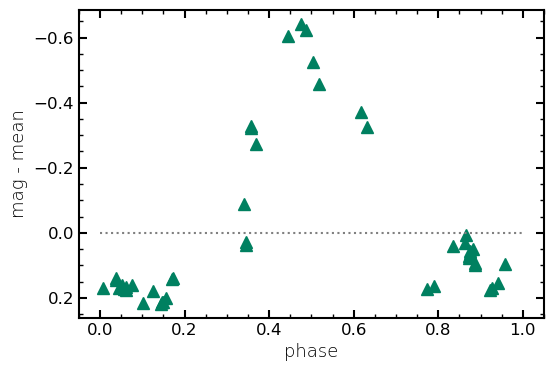

DiaObjectID:  1567762843720221100 
 RA:  62.5202159 
 Dec:  -37.8646632 
 period:  0.27815487936846894


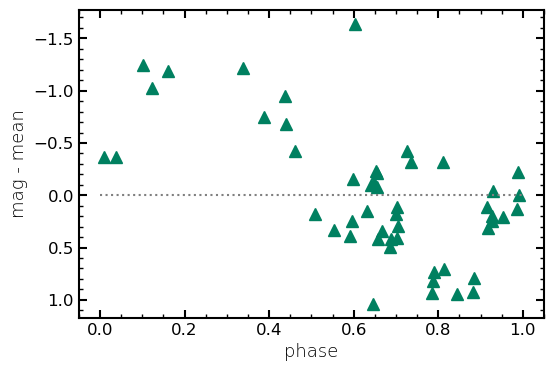

DiaObjectID:  1651589610221862935 
 RA:  62.1479038 
 Dec:  -35.7991348 
 period:  0.5095088304909955


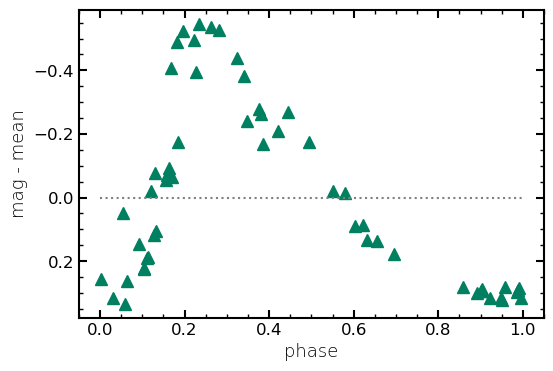

In [67]:
objid_index = [0,1,7]

for i in objid_index:
    fig = plt.figure(figsize=(6, 4))
    findobj = (fsodo_sources['diaObjectId'] == objids[i])
    obj_mjd_days = np.array(fsodo_sources[findobj]['expMidptMJD']) * u.day
    obj_mags = np.array(fsodo_sources[findobj]['fsodo_gmag'])
    obj_period = 1 / LSfreq[i]
    print('DiaObjectID: ', objids[i],
          '\n RA: ', fsodo_sources[findobj]['ra'][0],
          '\n Dec: ', fsodo_sources[findobj]['decl'][0],
          '\n period: ', obj_period)

    t0 = 0.0
    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    plt.plot(obj_phase, obj_mags-np.nanmean(obj_mags), plot_filter_symbols['g'],
             color=plot_filter_colors['g'], ms=8)
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.gca().invert_yaxis()
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

Hooray! A few of these look like actual RR Lyrae variables! Some of the others either aren't RR Lyrae, or have mis-identified periods.

Note that the lightcurve with `DiaObjectId` 1651589610221862935 is the same as the one we target in Section 2.

### 5.4 Cautionary tale: comparing lightcurves from ForcedSourceOnDiaObject vs. DiaSource

**What if we used `DiaSource` instead of `ForcedSourceOnDiaObject`?** 

In this section we demonstrate the results when we perform a table JOIN between `DiaObject` and `DiaSource` instead of `ForcedSourceOnDiaObject`.
Using `DiaSource` will only provide photometry measurements for visits in which the variable star is detected in the 
difference image (the detection threshold is a signal-to-noise ratio greater than 5).
Variable stars will not be detected in a difference image when they are nearly the same brightness as they are in the template image, leaving a very small flux residual in the difference image.

As demonstrated below, using `DiaSource` instead of `ForcedSourceOnDiaObject` can leave some points out of the
lightcurve and impact any derived parameters like the period.

First, we perform a similar search query as Sec. 5.1 except we use a table JOIN with `DiaSource`.
Note that `totFlux` from `DiaSource` provides the forced PSF-flux measurement on the direct image, not the difference image

In [68]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxMin, diao.gPSFluxMax, diao.gPSFluxMean, diao.gPSFluxSigma, "\
        "diao.gPSFluxMAD, diao.gPSFluxChi2, diao.gPSFluxNdata, diao.gPSFluxSkew, "\
        "diao.gPSFluxStetsonJ, diao.gPSFluxPercentile05, diao.gPSFluxPercentile25, "\
        "diao.gPSFluxPercentile50, diao.gPSFluxPercentile75, diao.gPSFluxPercentile95, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(diao.gTOTFluxMean) as diao_gmag, "\
        "dias.diaSourceId, dias.diaObjectId, dias.midPointTai, "\
        "dias.ccdVisitId, dias.filterName, dias.psFlux, dias.psFluxErr, "\
        "dias.totFlux, dias.totFluxErr, "\
        "scisql_nanojanskyToAbMag(dias.totFlux) as dias_gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.DiaSource as dias "\
        "ON dias.diaObjectId = diao.diaObjectId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND dias.filterName = 'g' "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
dia_sources = results.to_table()

In [69]:
print(len(dia_sources), len(np.unique(dia_sources['diaObjectId'])))

549 14


The query returned 14 unique `DiaObjects`, the same as the query from Section 3.1.
However, the query with `DiaSource` resulted in a total of 549 measurements, whereas the query with `ForcedSourceOnDiaObject` resulted in a total of 702 measurements.

We now repeat the same Lomb-Scargle analysis with the `DiaSource` results.

In [70]:
objids_dia = np.unique(dia_sources['diaObjectId'])
LSpower_dia = []
LSfreq_dia = []

minfreq = 1 / (1.25*u.d)
maxfreq = 1 / (0.05*u.d)
for objid in objids:
    findobj = (dia_sources['diaObjectId'] == objid)
    obj_mjd_days = np.array(dia_sources[findobj]['midPointTai']) * u.day
    obj_mags = np.array(dia_sources[findobj]['dias_gmag'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days, obj_mags).autopower(minimum_frequency=minfreq,
                                                      maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    LSpower_dia.append(obj_power[max_power])
    LSfreq_dia.append(obj_frequency[max_power].value)

LSpower_dia = np.array(LSpower_dia)
LSfreq_dia = np.array(LSfreq_dia)

We now plot the resulting phased lightcurves from the `DiaSource` catalog (open markers) and the `ForcedSourceOnDiaObject` catalog (filled markers) of the same 3 selected candidates.

DiaObjectID:  1567428592185376787 
 RA:  59.4814837 
 Dec:  -37.7323315 
 period (DiaSource):  1.0418601712065714 
 period (ForcedSourceOnDiaObject) 1.0418601712065714


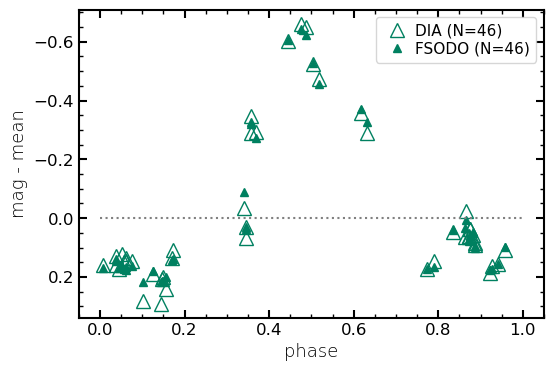

DiaObjectID:  1567762843720221100 
 RA:  62.5202159 
 Dec:  -37.8646632 
 period (DiaSource):  0.6515237959596147 
 period (ForcedSourceOnDiaObject) 0.27815487936846894


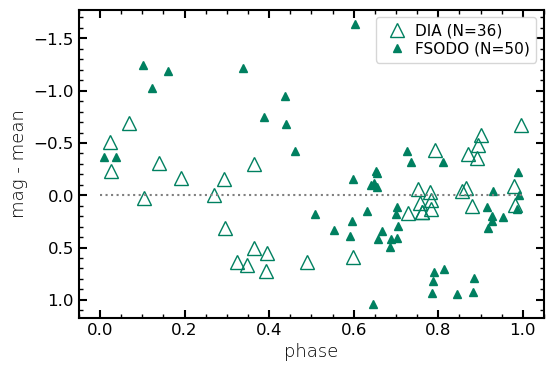

DiaObjectID:  1651589610221862935 
 RA:  62.1479038 
 Dec:  -35.7991348 
 period (DiaSource):  0.5095414310681814 
 period (ForcedSourceOnDiaObject) 0.5095088304909955


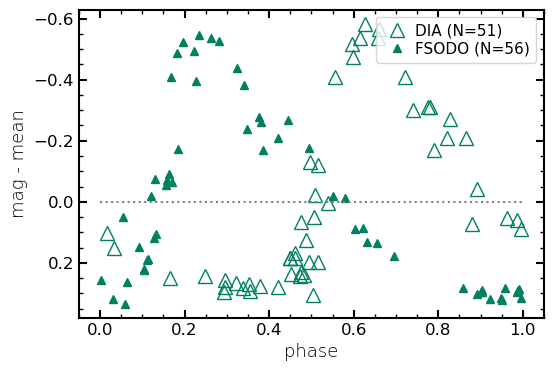

In [71]:
for i in objid_index:
    fig = plt.figure(figsize=(6, 4))    
    findobj_fsodo = (fsodo_sources['diaObjectId'] == objids[i])
    findobj_dia = (dia_sources['diaObjectId'] == objids[i])
    obj_mjd_days_dia = np.array(dia_sources[findobj_dia]['midPointTai']) * u.day
    obj_mags_dia = np.array(dia_sources[findobj_dia]['dias_gmag'])
    obj_mjd_days_fsodo = np.array(fsodo_sources[findobj_fsodo]['expMidptMJD']) * u.day
    obj_mags_fsodo = np.array(fsodo_sources[findobj_fsodo]['fsodo_gmag'])
    obj_period_fsodo = 1 / LSfreq[i]
    obj_period_dia = 1 / LSfreq_dia[i]
    print('DiaObjectID: ', objids[i],
          '\n RA: ', fsodo_sources[findobj_fsodo]['ra'][0],
          '\n Dec: ', fsodo_sources[findobj_fsodo]['decl'][0],
          '\n period (DiaSource): ', obj_period_dia,
          '\n period (ForcedSourceOnDiaObject)',obj_period_fsodo)
    
    t0 = 0.0
    obj_mjd_norm_fsodo = (obj_mjd_days_fsodo.value - t0) / obj_period_fsodo
    obj_mjd_norm_dia = (obj_mjd_days_dia.value - t0) / obj_period_dia
    obj_phase_dia = np.mod(obj_mjd_norm_dia, 1.0)
    obj_phase_fsodo = np.mod(obj_mjd_norm_fsodo, 1.0)

    plt.plot(obj_phase_dia, obj_mags_dia-np.nanmean(obj_mags_dia), plot_filter_symbols['g'],
             markerfacecolor = 'none', mec=plot_filter_colors['g'], ms=10, 
             label='DIA (N=%i)' % len(obj_phase_dia))
    plt.plot(obj_phase_fsodo, obj_mags_fsodo-np.nanmean(obj_mags_fsodo), plot_filter_symbols['g'],
             color=plot_filter_colors['g'], ms=6, label='FSODO (N=%i)' % len(obj_phase_fsodo))
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.gca().invert_yaxis()
    plt.legend(loc='upper right', labelspacing=0.2, handletextpad=0.2, fontsize=11)
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

Note that the number of measurements is always greater from the `ForcedSourceOnDiaObject` results.

The plots demonstrate the possible deviations in this analysis using the different catalogs.
Not only can the periods differ from using the different catalogs (e.g. 1567762843720221100), but the phase may also be offset due to additional measurements provided by the `ForcedSourceOnDiaObject` catalog. 

Lastly, we can estimate the fraction of candidates that will have different periods between the ForcedSourceOnDiaObject and DiaSource catalogs.

In [72]:
1-(LSfreq_dia-LSfreq).tolist().count(0.0)/len(LSfreq)

0.7142857142857143

We see that **~70%** of the identified candidates exhibit different periods from both catalogs.

Plot a histogram of the absolute difference in the periods measured from `ForcedSourceOnDiaObject` and `DiaSource`.

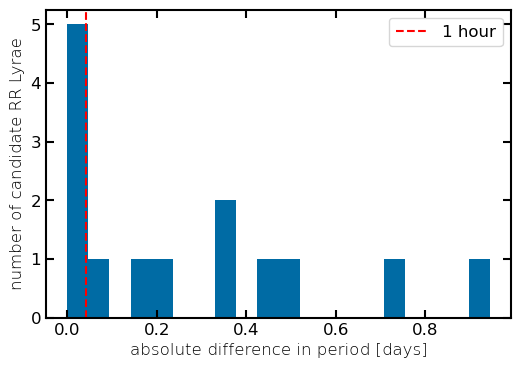

In [73]:
period_difference = np.abs((1.0 / LSfreq_dia) - (1.0 / LSfreq))

fig = plt.figure(figsize=(6, 4))
plt.hist(period_difference, bins=20)
plt.axvline(1.0 / 24.0, ls='--', color='red', label='1 hour')
plt.legend(loc='upper right')
plt.xlabel('absolute difference in period [days]', fontsize=12)
plt.ylabel('number of candidate RR Lyrae', fontsize=12)
plt.show()

Above, we can see that only 5 of the 14 candidate RR Lyrae (which have not been confirmed to _be_ RR Lyrae) have
periods that change by less than 1 hour when the incomplete `DiaSource` photometry is used instead of `ForcedSourceOnDiaObject`.

> Note: because of the source association issue pointed out at the end of Section 3.1, there are two `DiaObject` IDs from
the search that correspond to the same candidate.
This means that the fraction of unique RR Lyrae stars with different periods should actually be _greater_ than ~70%.